<a href="https://colab.research.google.com/github/z-arabi/pytorchTutorial/blob/master/15_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

The ImageFolder dataset  
The Scheduler to change the learning rate  
  
here we want to classify the bees and ants 

In [2]:
! git clone https://github.com/z-arabi/pytorchTutorial.git
% cd pytorchTutorial
% pwd

Cloning into 'pytorchTutorial'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 562 (delta 68), reused 477 (delta 18), pack-reused 0
Receiving objects: 100% (562/562), 52.77 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/pytorchTutorial


'/content/pytorchTutorial'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# normalize to [-1,1]
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)
print(image_datasets['train'][0])

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: data/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: data/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )}
(tensor([[[-0.6824, -0.6824, -0.6980,  ..., -0.7451, -0.7294, -0.7294],
         [-0.6980, -0.7137, -0.7137,  ..., -0.7294, -0.7294, -0.7294],
         [-0.6980, -0.7137, -0.7137,  ..., -0.7137, -0.7294, -

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
print(dataloaders)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f7d3b683f50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f7d3b699090>}
{'train': 244, 'val': 153}
['ants', 'bees']


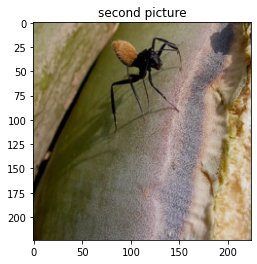

In [7]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()
imshow(image_datasets['train'][2][0], title="second picture")

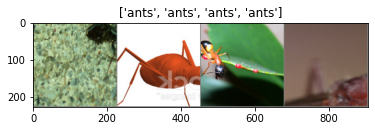

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
# Let's use transfer learning
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)

# change the last fully connected layers > input features
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6257 Acc: 0.6557
val Loss: 0.4962 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.5195 Acc: 0.7828
val Loss: 0.3677 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4700 Acc: 0.7664
val Loss: 0.3020 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4556 Acc: 0.8156
val Loss: 0.2747 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3671 Acc: 0.8320
val Loss: 0.2365 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4154 Acc: 0.7992
val Loss: 0.2181 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3769 Acc: 0.8320
val Loss: 0.2037 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4153 Acc: 0.8115
val Loss: 0.1994 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4693 Acc: 0.8033
val Loss: 0.2100 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3526 Acc: 0.8443
val Loss: 0.2104 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3333 Acc: 0.8689
val Loss: 0.2006 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.4050 Acc: 0.8197
val Loss: 0.2066 Acc: 0.9542

Ep

In [12]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5336 Acc: 0.7213
val Loss: 0.2222 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4014 Acc: 0.8197
val Loss: 0.1908 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.5738 Acc: 0.7664
val Loss: 0.2414 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5656 Acc: 0.7828
val Loss: 0.3706 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.4746 Acc: 0.7910
val Loss: 0.2846 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4923 Acc: 0.8197
val Loss: 0.1815 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3883 Acc: 0.8115
val Loss: 0.1612 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3916 Acc: 0.8156
val Loss: 0.1848 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3861 Acc: 0.8156
val Loss: 0.1543 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3627 Acc: 0.8361
val Loss: 0.1664 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3182 Acc: 0.8402
val Loss: 0.1752 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3306 Acc: 0.8484
val Loss: 0.1661 Acc: 0.9477

Ep